In [ ]:
!pip install mlflow codecarbon scikit-learn pandas
!pip install numpy==1.24.4


In [ ]:
!pip -q install feast scikit-learn pandas matplotlib seaborn codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.7/431.7 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.8/459

1. Data Prep

In [ ]:
import pandas as pd
import numpy as np
data = pd.read_csv('/athletes.csv')


In [ ]:
import os
print("当前工作目录:", os.getcwd())
print("该目录下的文件列表:", os.listdir())


当前工作目录: /content
该目录下的文件列表: ['.config', 'sample_data']


In [ ]:
  # Remove not relevant columns
data = data.dropna(subset=['region','age','weight','height','howlong','gender','eat',
                               'train','background','experience','schedule','howlong',
                               'deadlift','candj','snatch','backsq','experience',
                               'background','schedule','howlong'])
data = data.drop(columns=['affiliate','team','name','athlete_id','fran','helen','grace',
                              'filthy50','fgonebad','run400','run5k','pullups','train'])

    # Remove Outliers

data = data[data['weight'] < 1500]
data = data[data['gender'] != '--']
data = data[data['age'] >= 18]
data = data[(data['height'] < 96) & (data['height'] > 48)]

data = data[(data['deadlift'] > 0) & (data['deadlift'] <= 1105)|((data['gender'] == 'Female')
                 & (data['deadlift'] <= 636))]
data = data[(data['candj'] > 0) & (data['candj'] <= 395)]
data = data[(data['snatch'] > 0) & (data['snatch'] <= 496)]
data = data[(data['backsq'] > 0) & (data['backsq'] <= 1069)]

    # Clean Survey Data

decline_dict = {'Decline to answer|': np.nan}
data = data.replace(decline_dict)
data = data.dropna(subset=['background','experience','schedule','howlong','eat'])

In [ ]:
lift_cols = ['candj', 'snatch', 'deadlift', 'backsq']
data['total_lift'] = data[lift_cols].sum(axis=1)
target = 'total_lift'

features = ['gender', 'age', 'height', 'weight', 'candj', 'snatch', 'deadlift', 'backsq', 'region']
data_model = data[features + [target]].copy()

print(data_model.head())

data.to_parquet("athletes_data.parquet")
data.to_csv("athletes_data.csv")
print("Saved processed data as both CSV and Parquet formats")


   gender   age  height  weight  candj  snatch  deadlift  backsq  \
21   Male  30.0    71.0   200.0  235.0   175.0     385.0   315.0   
22   Male  28.0    70.0   176.0  187.0   134.0     335.0   254.0   
27   Male  35.0    68.0   225.0  285.0   205.0     440.0   405.0   
50   Male  36.0    71.0   199.0  267.0   212.0     485.0   390.0   
60   Male  36.0    64.0   155.0  245.0   180.0     415.0   385.0   

                 region  total_lift  
21  Southern California      1110.0  
22               Africa       910.0  
27           North East      1335.0  
50        North Central      1354.0  
60           North East      1225.0  
Saved processed data as both CSV and Parquet formats


2. Two different versions of features

In [ ]:
%%writefile feature_repo/feature_definition.py

from feast import FeatureView, FileSource, Entity, Field
from feast.types import Float32
from datetime import timedelta

file_source = FileSource(
    path="/content/athletes_data.parquet",
    timestamp_field="event_timestamp",
)


athlete = Entity(name="athlete_id", join_keys=["athlete_id"])


athlete_strength_view = FeatureView(
    name="athlete_strength_view",
    entities=[athlete],
    ttl=timedelta(days=30),
    schema=[
        Field(name="squat", dtype=Float32),
        Field(name="bench", dtype=Float32),
        Field(name="deadlift", dtype=Float32),
    ],
    online=True,
    source=file_source,
)

athlete_olympic_view = FeatureView(
    name="athlete_olympic_view",
    entities=[athlete],
    ttl=timedelta(days=30),
    schema=[
        Field(name="snatch", dtype=Float32),
        Field(name="clean", dtype=Float32),
        Field(name="jerk", dtype=Float32),
    ],
    online=True,
    source=file_source,
)


Writing feature_repo/feature_definition.py


In [ ]:
!mkdir -p feature_repo


In [ ]:
%%writefile feature_repo/feature_store.yaml
project: feature_repo
registry: data/registry.db
provider: local
online_store:
    type: sqlite
    path: data/online_store.db


Overwriting feature_repo/feature_store.yaml


In [ ]:
!cd feature_repo && feast apply


2025-07-16 20:52:19.719051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752699139.757907    6129 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752699139.770110    6129 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/content/feature_repo/feature_definition.py:13: DeprecationWarning: Entity value_type will be mandatory in the next release. Please specify a value_type for entity 'athlete_id'.
  athlete = Entity(name="athlete_id", join_keys=["athlete_id"])
No project found in the repository. Using project name feature_repo defined in feature_store.yaml
Applying changes for project feature_repo
/usr/local/lib/python3.11/dist-packages/feast/feature_v

3. Generate training dataset

In [4]:
import pandas as pd

df = pd.read_parquet("/content/athletes_data.parquet").dropna()

# Feature version 1: Olympic lifts
features_v1 = df[["candj", "snatch", "total_lift"]]

# Feature version 2: Powerlifting + body
features_v2 = df[["deadlift", "backsq", "weight", "height"]]

target = (df["gender"] == "Male").astype(int)



In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

experiment_log = []

def train_with_tracking(X, y, feature_version, hp_version, penalty="l2", C=1.0):
    from codecarbon import EmissionsTracker
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score

    tracker = EmissionsTracker()
    tracker.start()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(penalty=penalty, C=C, solver="liblinear")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)

    emissions = tracker.stop()


    experiment_log.append({
        "run_name": f"{feature_version}_{hp_version}",
        "feature_version": feature_version,
        "hyperparameters": hp_version,
        "accuracy": acc,
        "emissions_kg": emissions
    })

    return acc, emissions


In [9]:
train_with_tracking(features_v1, target, feature_version="v1", hp_version="hp1", penalty="l2", C=1.0)
train_with_tracking(features_v1, target, feature_version="v1", hp_version="hp2", penalty="l1", C=0.1)
train_with_tracking(features_v2, target, feature_version="v2", hp_version="hp1", penalty="l2", C=1.0)
train_with_tracking(features_v2, target, feature_version="v2", hp_version="hp2", penalty="l1", C=0.1)


print("V1 + (l2, C=1.0):", acc1)
print("V1 + (l1, C=0.1):", acc2)
print("V2 + (l2, C=1.0):", acc3)
print("V2 + (l1, C=0.1):", acc4)


[codecarbon WARNING @ 04:10:25] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 04:10:25] [setup] RAM Tracking...
[codecarbon INFO @ 04:10:25] [setup] CPU Tracking...
[codecarbon WARNING @ 04:10:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 04:10:26] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 04:10:26] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 04:10:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 04:10:26] [setup] GPU Tracking...
[codecarbon INFO @ 04:10:26] No GPU found.
[codecarbon INFO @ 04:10:26] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

V1 + (l2, C=1.0): 0.9067599067599068
V1 + (l1, C=0.1): 0.9074259074259075
V2 + (l2, C=1.0): 0.9368964368964369
V2 + (l1, C=0.1): 0.9417249417249417


4. Model Comparison

In [10]:
import pandas as pd
results_df = pd.DataFrame(experiment_log)

print("\n——— Quantitative Experiment Results Table ——")
print(results_df)



——— Quantitative Experiment Results Table ——
  run_name feature_version hyperparameters  accuracy  emissions_kg
0   v1_hp1              v1             hp1  0.906760      0.000001
1   v1_hp2              v1             hp2  0.907426      0.000005
2   v2_hp1              v2             hp1  0.936896      0.000002
3   v2_hp2              v2             hp2  0.941725      0.000012


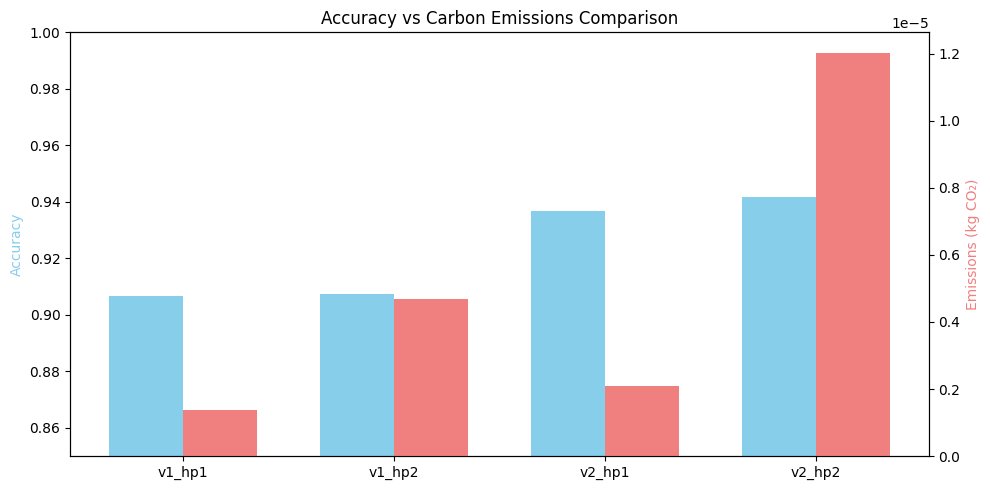

In [11]:
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots(figsize=(10, 5))

bar_width = 0.35
x = range(len(results_df))

# Accuracy bars
ax1.bar(x, results_df["accuracy"], width=bar_width, label="Accuracy", color="skyblue")
ax1.set_ylabel("Accuracy", color="skyblue")
ax1.set_ylim(0.85, 1.0)

# Emissions bars (second y-axis)
ax2 = ax1.twinx()
ax2.bar([i + bar_width for i in x], results_df["emissions_kg"], width=bar_width, label="Emissions (kg)", color="lightcoral")
ax2.set_ylabel("Emissions (kg CO₂)", color="lightcoral")

# X ticks
combined_labels = results_df["run_name"]
plt.xticks([i + bar_width/2 for i in x], combined_labels)

plt.title("Accuracy vs Carbon Emissions Comparison")
fig.tight_layout()
plt.show()



In [12]:
from sklearn.linear_model import LogisticRegression

# features_v1
model_v1 = LogisticRegression(penalty="l2", C=1.0, solver="liblinear")
model_v1.fit(features_v1, target)
importance_v1 = model_v1.coef_[0]
feature_names_v1 = features_v1.columns

# features_v2
model_v2 = LogisticRegression(penalty="l2", C=1.0, solver="liblinear")
model_v2.fit(features_v2, target)
importance_v2 = model_v2.coef_[0]
feature_names_v2 = features_v2.columns


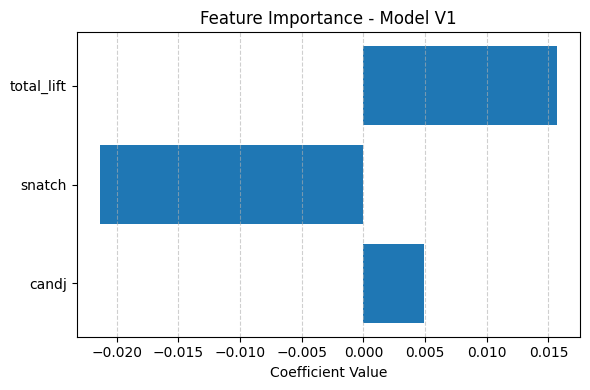

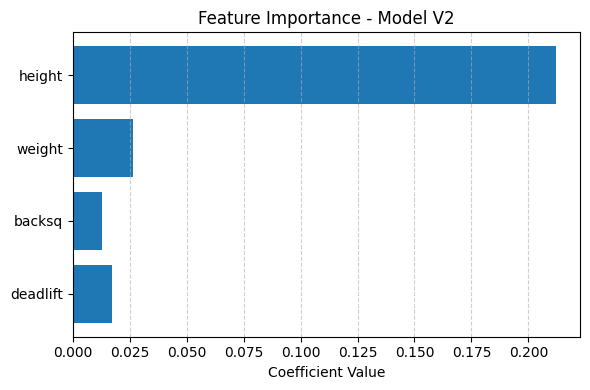

In [13]:
# V1
plt.figure(figsize=(6, 4))
plt.barh(feature_names_v1, importance_v1)
plt.title("Feature Importance - Model V1")
plt.xlabel("Coefficient Value")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# V2
plt.figure(figsize=(6, 4))
plt.barh(feature_names_v2, importance_v2)
plt.title("Feature Importance - Model V2")
plt.xlabel("Coefficient Value")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
